In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import imblearn.over_sampling as smote
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore", category=FutureWarning)

# ETL

In [3]:
df = pd.read_csv('fraude_bacario.csv')

In [4]:
#df.to_parquet("D:/bootcamp_experience/Bootcamp-machineLearning/fraude_bacario.parquet")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.duplicated().sum()

0

Creando una nueva columna type2 conn las iniciales de 'nameOrig' y 'nameDest'

In [9]:
df['type2'] = df['nameOrig'].str[0] + df['nameDest'].str[0]
columna = df['type2']
del df['type2']
df.insert(2,'type2', columna) # se mueve la columna a la posicion 2 para tener mas orden
df.head()

,step,type,type2,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,CM,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,CM,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,CC,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,CC,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,CM,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Se eliminan columnas innecesarias

In [10]:
df.drop(columns=['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], inplace=True)

### Se verifica cuantos tipos de type y type2 hay

In [11]:
df['type'].value_counts().size

5

In [12]:
df['type2'].value_counts().size

2

In [13]:
df.head(3)

,step,type,type2,amount,isFraud
0,1,PAYMENT,CM,9839.64,0
1,1,PAYMENT,CM,1864.28,0
2,1,TRANSFER,CC,181.00,1


### Se convierte las columnans type y type2 en formato numerico, se van preparando los datos para el modelo de Machine Learning

In [14]:
df = pd.get_dummies(df, columns=['type', 'type2'],  dtype=int)

In [15]:
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


# EDA
Se realiza un boxplot de las columnas: 'isFraud', 'amount', 'step'

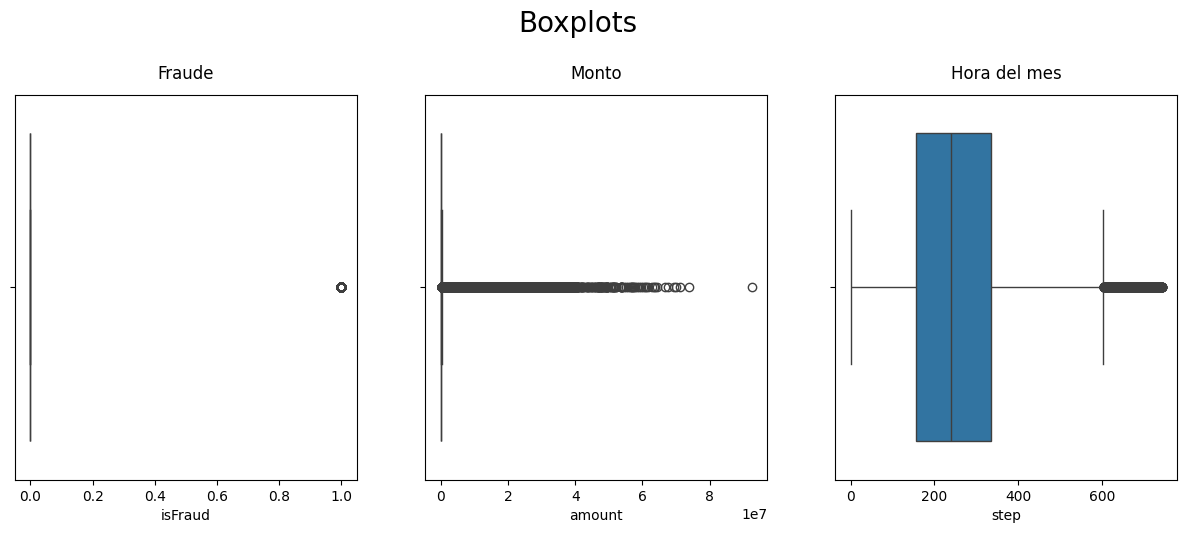

In [16]:
fig, axs = plt.subplots(1, 3, figsize= (15, 5))
fig.suptitle('Boxplots', fontsize=20, y=1.05)
sns.boxplot (x= 'isFraud', data = df, ax=axs[0]).set_title('Fraude', fontsize=12, y=1.02)
sns.boxplot (x= 'amount', data = df, ax=axs[1]).set_title('Monto', fontsize=12, y=1.02)
sns.boxplot (x= 'step', data = df, ax=axs[2]).set_title('Hora del mes', fontsize=12, y=1.02);


### Se crea una matriz de correlación

In [17]:
df.head()

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0
3,1,181.00,1,0,1,0,0,0,1,0
4,1,11668.14,0,0,0,0,1,0,0,1


### Se verifica si esta balanceada la etiqueta objetivo

In [20]:
distribucion_isFraud = df['isFraud'].value_counts()
distribucion_isFraud

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [21]:
f'{round((8213/6354407)*100, 2)} %'

'0.13 %'

Como se observa solo el 0.13% de los datos de la etiqueta objetivo pertenecen a la categoria fraude, por lo tannto es necesario balancear los datos

Ahora observamos el desbalnaceo graficamente

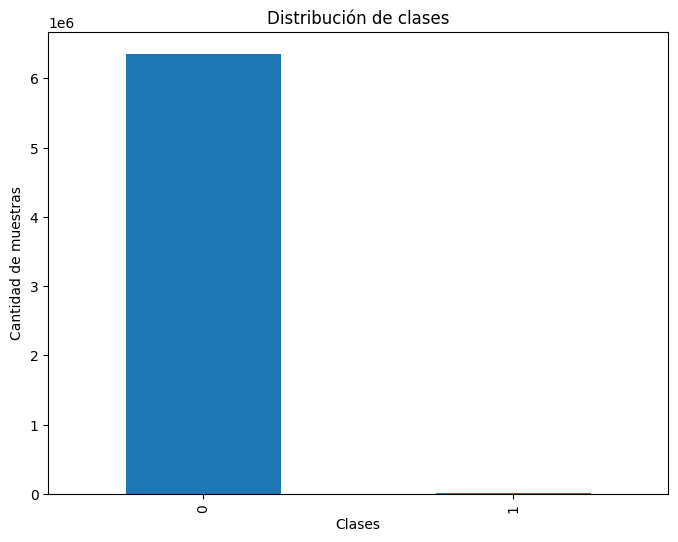

In [22]:
plt.figure(figsize=(8, 6))
distribucion_isFraud.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad de muestras');

### Balanceando la etiqueta objetivo

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

In [24]:
df.head(3)

,step,amount,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,0,0,0,0,1,0,0,1
1,1,1864.28,0,0,0,0,1,0,0,1
2,1,181.00,1,0,0,0,0,1,1,0


In [25]:
def balanceo_clases(dataset, ruta_archivo):
    # Separate features and target variable
    X = df.drop("isFraud", axis=1)  # Assuming "isFraud" is the target column
    y = df["isFraud"]

    # Create the SMOTE object with appropriate parameters (adjust k as needed)
    sm = smote.SMOTE(k_neighbors=5, random_state=42)

    # Oversample the data using SMOTE
    X_resampled, y_resampled = sm.fit_resample(X, y)

    # Combine the resampled features and target variable
    resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

    # Print the shapes of original and resampled data to verify balancing
    print("Original data shape:", df.shape)
    print("Resampled data shape:", resampled_data.shape)

    # Save the resampled data (optional)
    resampled_data.to_csv(ruta_archivo, index=False)

balanceo_clases(df, "balanced_data.csv")



Original data shape: (6362620, 10)
Resampled data shape: (12708814, 10)


Se carga el dataset balaceado

In [26]:
df_balanceado = pd.read_csv('balanced_data.csv')

Se verifican cuando valores duplicados fueron creados

In [27]:
df_balanceado.duplicated().sum()

1452538

Se borran los duplicados

In [28]:
df_balanceado.drop_duplicates(inplace=True)

Se realiza la matriz de correlación

In [44]:
matriz_correlacion = df_balanceado.corr()
matriz_correlacion

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
step,1.000000,0.124723,-0.112256,-0.045732,-0.016728,-0.144817,0.083093,0.144817,-0.144817,0.347048
amount,0.124723,1.000000,-0.120962,-0.040988,-0.026825,-0.211605,0.152181,0.211605,-0.211605,0.361028
type_CASH_IN,-0.112256,-0.120962,1.000000,-0.251587,-0.022896,-0.182924,-0.162022,0.182924,-0.182924,-0.331320
type_CASH_OUT,-0.045732,-0.040988,-0.251587,1.000000,-0.040590,-0.324283,-0.287229,0.324283,-0.324283,-0.106818
type_DEBIT,-0.016728,-0.026825,-0.022896,-0.040590,1.000000,-0.029512,-0.026140,0.029512,-0.029512,-0.053454
type_PAYMENT,-0.144817,-0.211605,-0.182924,-0.324283,-0.029512,1.000000,-0.208839,-1.000000,1.000000,-0.427056
type_TRANSFER,0.083093,0.152181,-0.162022,-0.287229,-0.026140,-0.208839,1.000000,0.208839,-0.208839,0.229448
type2_CC,0.144817,0.211605,0.182924,0.324283,0.029512,-1.000000,0.208839,1.000000,-1.000000,0.427056
type2_CM,-0.144817,-0.211605,-0.182924,-0.324283,-0.029512,1.000000,-0.208839,-1.000000,1.000000,-0.427056
isFraud,0.347048,0.361028,-0.331320,-0.106818,-0.053454,-0.427056,0.229448,0.427056,-0.427056,1.000000


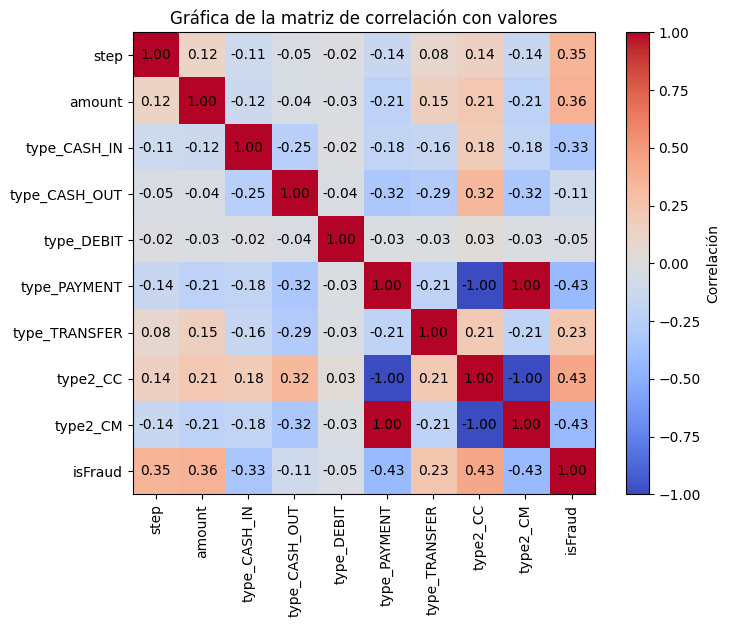

In [45]:
plt.figure(figsize=(8, 6))
plt.imshow(matriz_correlacion, cmap='coolwarm', interpolation='nearest')
plt.xticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns, rotation=90)
plt.yticks(np.arange(len(matriz_correlacion.columns)), matriz_correlacion.columns)
plt.colorbar(label='Correlación')
plt.title('Gráfica de la matriz de correlación con valores')
for i in range(len(matriz_correlacion.columns)):
    for j in range(len(matriz_correlacion.columns)):
        plt.text(j, i, f'{matriz_correlacion.iloc[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

Se aplica un Standar Sacaler a la columna amount

In [29]:
# Seleccionar la etiqueta a normalizar
etiqueta_a_normalizar = 'amount'

# Inicializar StandardScaler
scaler = StandardScaler()

# Ajustar el escalador solo a la etiqueta
scaler.fit(df_balanceado[[etiqueta_a_normalizar]])

# Transformar la etiqueta
df_balanceado[etiqueta_a_normalizar] = scaler.transform(df_balanceado[[etiqueta_a_normalizar]])

# Ver el DataFrame resultante
df_balanceado.head()

,step,amount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM,isFraud
0,1,-0.438159,0,0,0,1,0,0,1,0
1,1,-0.444027,0,0,0,1,0,0,1,0
2,1,-0.445265,0,0,0,0,1,1,0,1
3,1,-0.445265,0,1,0,0,0,1,0,1
4,1,-0.436814,0,0,0,1,0,0,1,0


# Machine Learning
### Regresión logistica

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [31]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X = df_balanceado.drop(columns='isFraud')
y = df_balanceado['isFraud']

# Se dividen los datos en conjunto de prueba y entrenamiento
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Se crea y entrena el modelo
model = LogisticRegression(max_iter=200)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Se calcula la presición del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)


Accuracy del modelo: 0.8845089141350428
Precisión del modelo: 0.8920550895759284


### Arboles de decisión

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
# Se crea el modelo y se entrena
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# Predicciones
y_pred = model.predict(x_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)


Accuracy del modelo: 0.9780127182337326
Precisión del modelo: 0.9665936664929202


### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
# Se inicializa y entrena el modelo
model = RandomForestClassifier(max_depth=30, n_estimators=12, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy)
print("Precisión del modelo:", precision)

Accuracy del modelo: 0.962946906082649
Precisión del modelo: 0.9683137117598144
